In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

!whoami
!date

beatrixh
Tue Jun 22 14:27:50 PDT 2021


# 2.0: WASTING (risk validation)

## wasting risk vv

In [22]:
%cd /ihme/costeffectiveness/results/vivarium_ciff_sam/v2.0_wasting/ciff_sam/2021_06_15_09_14_56/count_data
%ls

/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.0_wasting/ciff_sam/2021_06_15_09_14_56/count_data
deaths.csv                     population.csv                 ylds.csv
deaths.hdf                     population.hdf                 ylds.hdf
disease_state_person_time.csv  wasting_state_person_time.csv  ylls.csv
disease_state_person_time.hdf  wasting_state_person_time.hdf  ylls.hdf
disease_transition_count.csv   wasting_transition_count.csv
disease_transition_count.hdf   wasting_transition_count.hdf


In [23]:
master_dir = '/home/j/Project/simulation_science/ciff_malnutrition/'
sim_result_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.0_wasting/ciff_sam/2021_06_15_09_14_56/count_data/'
output_dir = master_dir + f'verification_and_validation/v2.0_wasting/'

## LOAD SIM DATA

In [24]:
def load_sim_count_data(sim_result_dir: str):
    columns = ['age', 'sex', 'year', 'input_draw', 'scenario', 'measure']
    df = {}
    fnames = ['deaths', 'disease_transition_count', 'wasting_transition_count',
              'disease_state_person_time', 'wasting_state_person_time']
    for fname in fnames:
        df[fname] = pd.read_csv(sim_result_dir + fname + '.csv', index_col=0)
        # get aggregated results if stratifications exist
        if 'cause' in df[fname].columns:
            df[fname] = df[fname].groupby(columns + ['cause']).value.sum().reset_index()
        else:
            df[fname] = df[fname].groupby(columns).value.sum().reset_index()
    return df

df = load_sim_count_data(sim_result_dir)

In [78]:
pd.read_csv(sim_result_dir + 'wasting_transition_count.csv', index_col=0).query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"')

,sex,year,measure,input_draw,scenario,value,age
240,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,0.0,early_neonatal
241,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,1.0,late_neonatal
242,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,4.0,post_neonatal
243,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,0.0,1_to_4
...,...,...,...,...,...,...,...
2876,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,0.0,early_neonatal
2877,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,0.0,late_neonatal
2878,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,1.0,post_neonatal
2879,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,0.0,1_to_4


In [85]:
sim_result_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.0_wasting/ciff_sam/2021_06_15_09_14_56/count_data/'

results = pd.read_csv(sim_result_dir + 'wasting_transition_count.csv', index_col=0)
incidence_mild_count = results.query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"')
incidence_mild_count.head()

,sex,year,measure,input_draw,scenario,value,age
240,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,0.0,early_neonatal
241,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,1.0,late_neonatal
242,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,4.0,post_neonatal
243,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,0.0,1_to_4
244,female,2022,susceptible_to_child_wasting_to_mild_child_was...,223,baseline,0.0,early_neonatal


In [84]:
incidence_mild_count \
.groupby(['year','age']) \
.sum().drop(columns='input_draw').reset_index().set_index(['age']) \
.pivot(columns = 'year')

value                        
year            2022  2023  2024  2025  2026
age                                         
1_to_4           0.0   0.0   0.0   0.0   0.0
early_neonatal   3.0   0.0   0.0   2.0   1.0
late_neonatal    3.0   7.0   5.0   3.0   1.0
post_neonatal   76.0  25.0  30.0  30.0  26.0

### WASTING STATE TRANSITION COUNTS

In [25]:
incidence_mild_count = (df['wasting_transition_count'].query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"'))
incidence_mild_count['risk'] = 'mild_wasting'
incidence_mild_count['measure'] = 'incidence'

incidence_mam_count = (df['wasting_transition_count'].query('measure == "mild_child_wasting_to_moderate_acute_malnutrition_event_count"'))
incidence_mam_count['risk'] = 'mam'
incidence_mam_count['measure'] = 'incidence'

incidence_sam_count = (df['wasting_transition_count'].query('measure == "moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count"'))
incidence_sam_count['risk'] = 'sam'
incidence_sam_count['measure'] = 'incidence'

remission_sam_count = (df['wasting_transition_count'].query('measure == "severe_acute_malnutrition_to_moderate_acute_malnutrition_event_count"'))
remission_sam_count['risk'] = 'sam'
remission_sam_count['measure'] = 'remission'

remission_mam_count = (df['wasting_transition_count'].query('measure == "moderate_acute_malnutrition_to_mild_child_wasting_event_count"'))
remission_mam_count['risk'] = 'mam'
remission_mam_count['measure'] = 'remission'

remission_mild_count = (df['wasting_transition_count'].query('measure == "mild_child_wasting_to_susceptible_to_child_wasting_event_count"'))
remission_mild_count['risk'] = 'mild_wasting'
remission_mild_count['measure'] = 'remission'

### WASTING STATE PERSON TIME

In [28]:
person_time_sus_wasting = df['wasting_state_person_time'].query('cause == "susceptible_to_child_wasting"')
person_time_mild_wasting = df['wasting_state_person_time'].query('cause == "mild_child_wasting"')
person_time_mam = df['wasting_state_person_time'].query('cause == "moderate_acute_malnutrition"')
person_time_sam = df['wasting_state_person_time'].query('cause == "severe_acute_malnutrition"')

#### TOTAL PERSON TIME

In [40]:
df['disease_person_time'] = df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])
].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()

df['disease_person_time']['cause'] = 'all_causes'

In [41]:
df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])].value.sum()

22186429.864476386

In [42]:
df['risk_person_time'] = df['wasting_state_person_time'].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()
df['risk_person_time']['cause'] = 'all_causes'

In [43]:
# i think the disease person time v risk person time should be equal
df['disease_person_time'].value.sum()

22186429.864476383

In [44]:
df['risk_person_time'].value.sum()

35234224.11362081

## CALCULATE SIM MEASURES

In [45]:
def get_measure(data: pd.DataFrame, denom: pd.DataFrame, entity: str):
    """
    rate per PY among source population
    note the numerator is 'data' and denominator is df['person_time']
    """
    
    result = ((data
               .set_index(['age', 'sex', 'year', 'input_draw', 'scenario', 'measure', entity])
               .div(denom.drop(columns=['measure', 'cause'])
                    .set_index(['age', 'sex', 'year', 'input_draw', 'scenario'])))
              .reset_index())
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == 'post_neonatal',3,
                                        4)))
    
    result_summary = (result
                      .groupby(['age_group', 'sex', 'year', 'scenario', 'measure', entity])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    
    return result_summary

In [46]:
df.keys()

dict_keys(['deaths', 'disease_transition_count', 'wasting_transition_count', 'disease_state_person_time', 'wasting_state_person_time', 'disease_person_time', 'risk_person_time'])

### PREVALENCE

In [35]:
# risk prevalence
prevalence_wasting_tmrel = get_measure(person_time_sus_wasting, df['risk_person_time'], 'cause')
prevalence_mild = get_measure(person_time_mild_wasting, df['risk_person_time'], 'cause')
prevalence_mam = get_measure(person_time_mam, df['risk_person_time'], 'cause')
prevalence_sam = get_measure(person_time_sam, df['risk_person_time'], 'cause')

### INCIDENCE

In [47]:
incidence_mild = get_measure(incidence_mild_count, denom = person_time_sus_wasting, entity = 'risk')
incidence_mam = get_measure(incidence_mam_count, denom = person_time_mild_wasting, entity = 'risk')
incidence_sam = get_measure(incidence_sam_count, denom = person_time_mam, entity = 'risk')

### REMISSION

In [48]:
remission_mild = get_measure(remission_mild_count, denom = person_time_mild_wasting, entity = 'risk')
remission_mam = get_measure(remission_mam_count, denom = person_time_mam, entity = 'risk')
remission_sam = get_measure(remission_sam_count, denom = person_time_sam, entity = 'risk')

# ARTIFACT

In [49]:
#filepath

%cd /ihme/costeffectiveness/artifacts/vivarium_ciff_sam/
%ls

/ihme/costeffectiveness/artifacts/vivarium_ciff_sam
ethiopia.hdf


In [50]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2019', 'age_start >=  0.076712', f'age_end <= 5'])

In [51]:
#load population structure

art_pop = art.load('population.structure').reset_index()

In [52]:
def load_wasting_prev(cat):
    data = art.load('risk_factor.child_wasting.exposure')
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                               np.where(data['age_end'] == 1, 'post_neonatal',
                                        np.where(data['age_start'] == 1, '1_to_4', 
                                                'late_neonatal')))

    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                               np.where(data['age'] == 'late_neonatal', 2,
                                        np.where(data['age'] == 'post_neonatal', 3, 
                                                4)))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'sam',
        'cat2':'mam',
        'cat3':'mild_wasting',
        'cat4':'tmrel_wasting'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.loc[data.parameter==cat].drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

In [45]:
sam_prev = load_wasting_prev('cat1')
mam_prev = load_wasting_prev('cat2')
mild_prev = load_wasting_prev('cat3')
sus_wasting_prev = load_wasting_prev('cat4')

# PLOT

In [61]:
def summarize_df(data: pd.DataFrame, entity: str):
    result = data.reset_index()
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == 'post_neonatal',3,
                                        4)))
    group_cols = ['age_group', 'sex', 'year', 'scenario', 'measure'] + [entity]
    
    result_summary = (result
                      .groupby(group_cols)
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    return result_summary

In [73]:
incidence_mild_count.groupby(['year','age']).sum().drop(columns='input_draw').reset_index().set_index(['age']).pivot(columns = 'year')

value                        
year            2022  2023  2024  2025  2026
age                                         
1_to_4           0.0   0.0   0.0   0.0   0.0
early_neonatal   3.0   0.0   0.0   2.0   1.0
late_neonatal    3.0   7.0   5.0   3.0   1.0
post_neonatal   76.0  25.0  30.0  30.0  26.0

In [70]:
incidence_mild_count.groupby(['year','age']).sum().reset_index().set_index(['age']).pivot(columns = 'year')#.pivot(columns='year')

input_draw                             value                    \
year                 2022   2023   2024   2025   2026  2022  2023  2024  2025   
age                                                                             
1_to_4              12190  12190  12190  12190  12190   0.0   0.0   0.0   0.0   
early_neonatal      12190  12190  12190  12190  12190   3.0   0.0   0.0   2.0   
late_neonatal       12190  12190  12190  12190  12190   3.0   7.0   5.0   3.0   
post_neonatal       12190  12190  12190  12190  12190  76.0  25.0  30.0  30.0   

                      
year            2026  
age                   
1_to_4           0.0  
early_neonatal   1.0  
late_neonatal    1.0  
post_neonatal   26.0

In [63]:
wasting_pt_df = summarize_df(df['wasting_state_person_time'], entity = 'cause')

pt_sam_df = summarize_df(person_time_sam, entity = 'cause')
pt_mam_df = summarize_df(person_time_mam, entity = 'cause')
pt_mild_df = summarize_df(person_time_mild_wasting, entity = 'cause')
pt_tmrel_wasting = summarize_df(person_time_sus_wasting, entity = 'cause')

inc_count_sam = summarize_df(incidence_sam_count, entity = 'risk')
inc_count_mam = summarize_df(incidence_mam_count, entity = 'risk')
inc_count_mild = summarize_df(incidence_mild_count, entity = 'risk')

rem_count_sam = summarize_df(remission_sam_count, entity = 'risk')
rem_count_mam = summarize_df(remission_mam_count, entity = 'risk')
rem_count_mild = summarize_df(remission_mild_count, entity = 'risk')

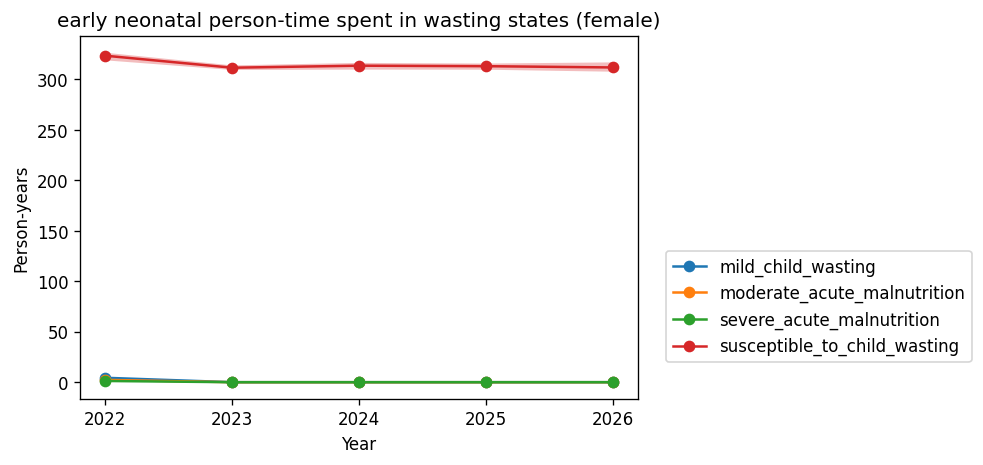

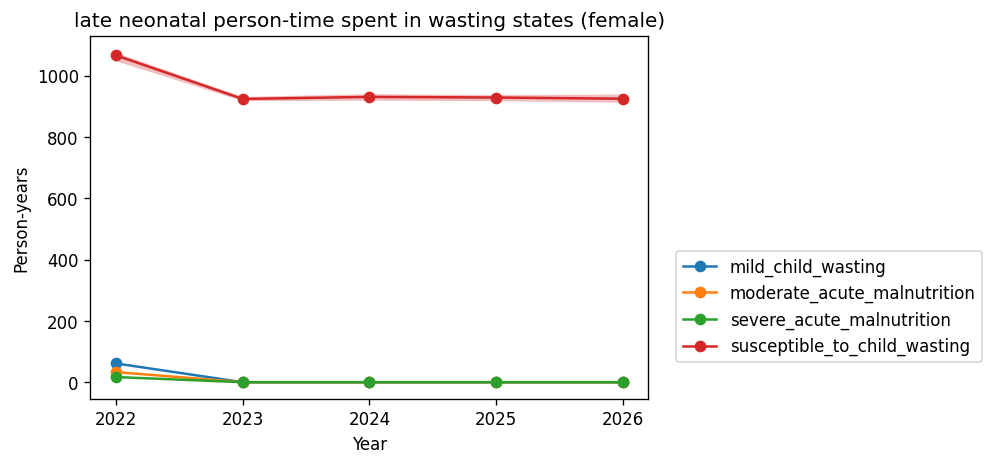

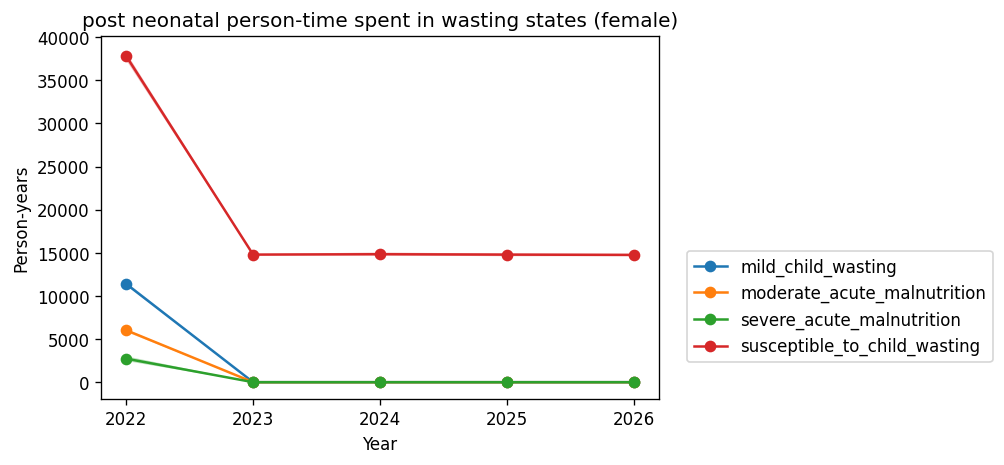

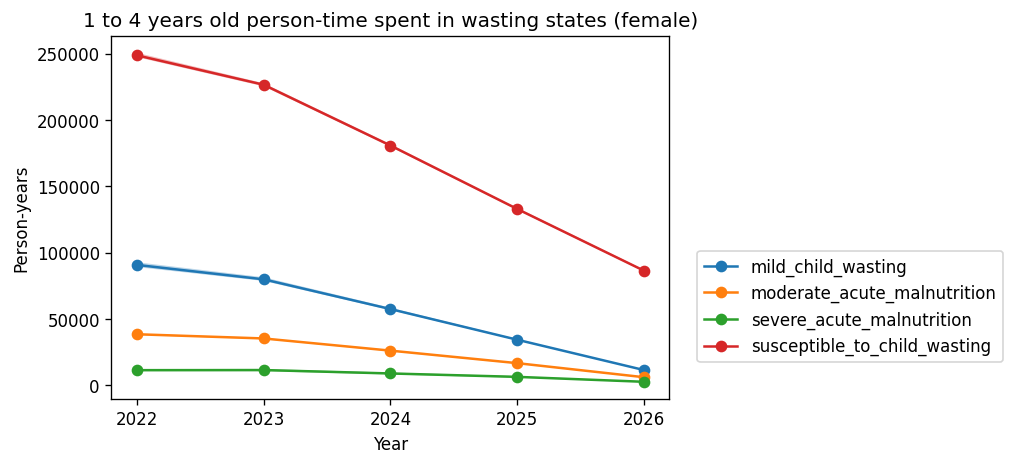

In [64]:
def plot_wasting_pt_over_time(df, sex, age_group):
    
    df.year = df.year.astype(int)
    state = df.cause.iloc[0]
    age_map = {1:'early neonatal',2:'late neonatal', 3:'post neonatal', 4: '1 to 4 years old'}
    age = age_map[age_group]
    
    plt.figure(figsize=(6, 4), dpi=120)
    for cause in df.cause.unique():
        sub = df.loc[(df.sex==sex) & (df.age_group==age_group) & (df.cause==cause)]
        plt.plot(sub['year'], sub['mean'], marker='o', label=cause)
        plt.fill_between(sub['year'], sub['2.5%'], sub['97.5%'], alpha=.3)

    plt.legend(loc=(1.05, .1))
    plt.xlabel('Year')
    plt.ylabel('Person-years')
    plt.xticks(ticks = range(df.year.min(), df.year.max()+1))#, labels = ['early neonatal', 'late neonatal', 'post neonatal', '1 to 4'], rotation = 45) 
    plt.title(f'{age} person-time spent in wasting states ({sex})')

for age_group in pt_tmrel_wasting.age_group.unique():
    plot_wasting_pt_over_time(wasting_pt_df, sex = 'female', age_group = age_group)

In [65]:
def plot_sim_wasting(sim_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1: 'early_neonatal', 2: 'late_neonatal', 3: 'post_neonatal', 4: '1_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4], labels = ['early neonatal', 'late neonatal', 'post neonatal', '1 to 4'], rotation = 45) 
          
    plt.legend(loc=(1.05, .1))
    plt.grid()
    

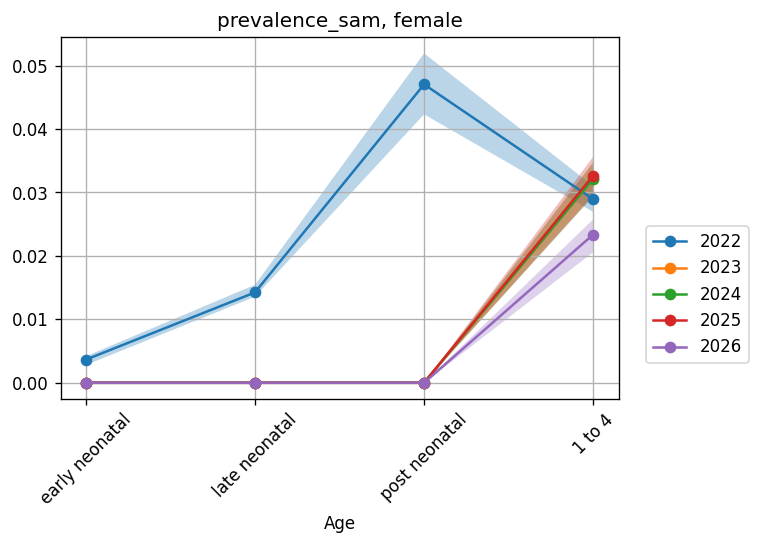

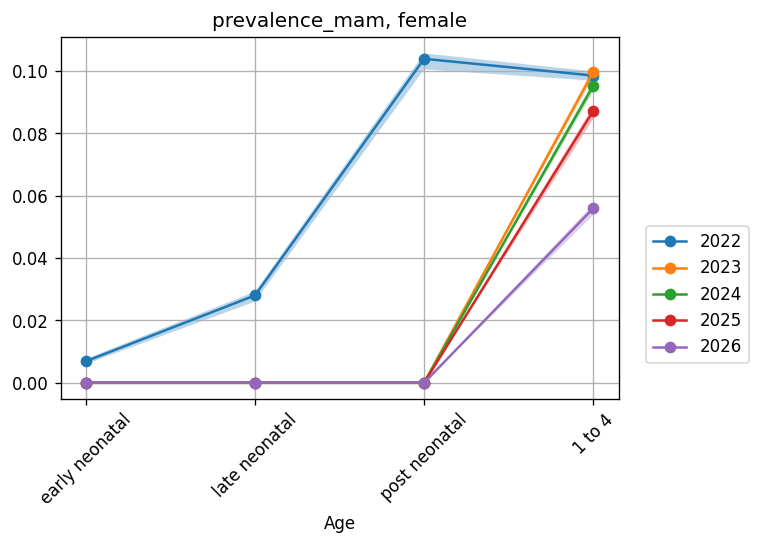

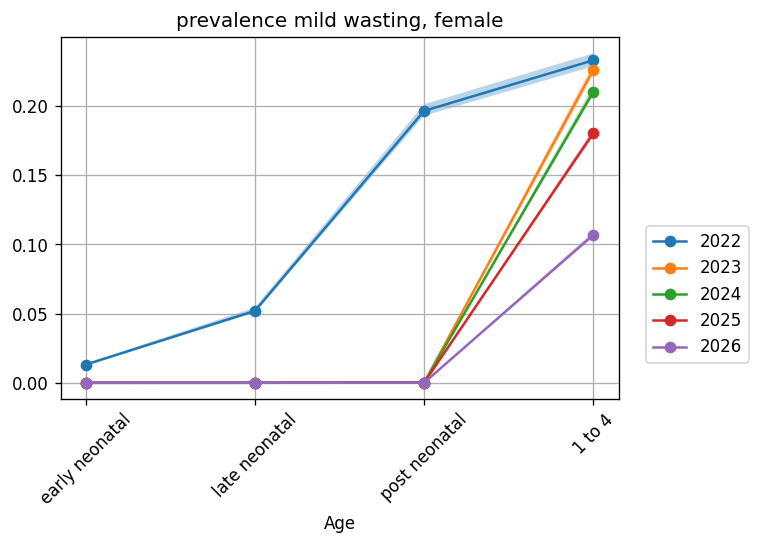

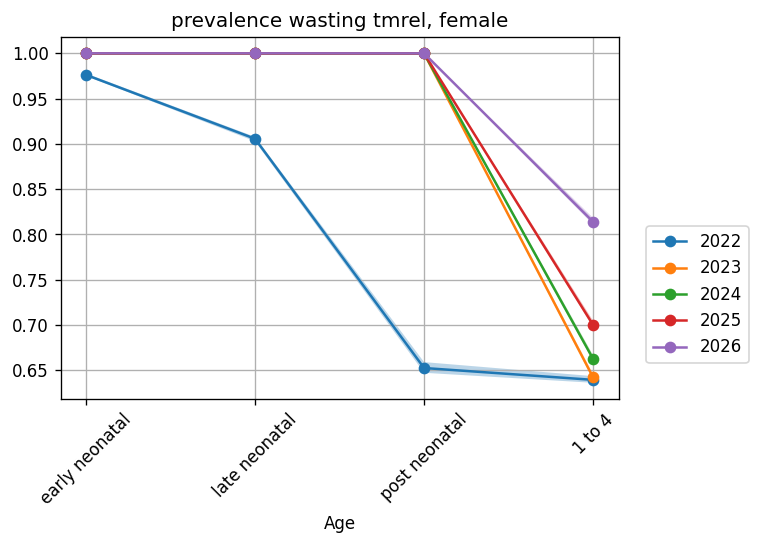

In [66]:
plot_sim_wasting(prevalence_sam, sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_wasting(prevalence_mam, sex = 'female', sim_measure = 'prevalence_mam')
plot_sim_wasting(prevalence_mild, sex = 'female', sim_measure = 'prevalence mild wasting')
plot_sim_wasting(prevalence_wasting_tmrel, sex = 'female', sim_measure = 'prevalence wasting tmrel')

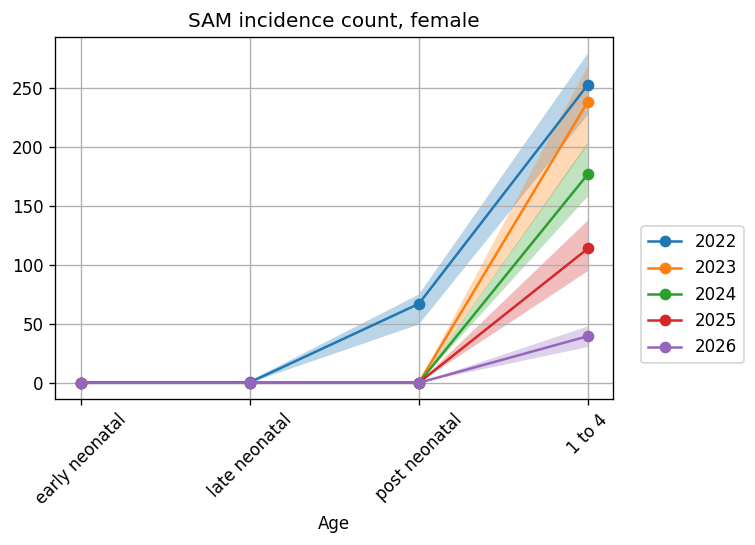

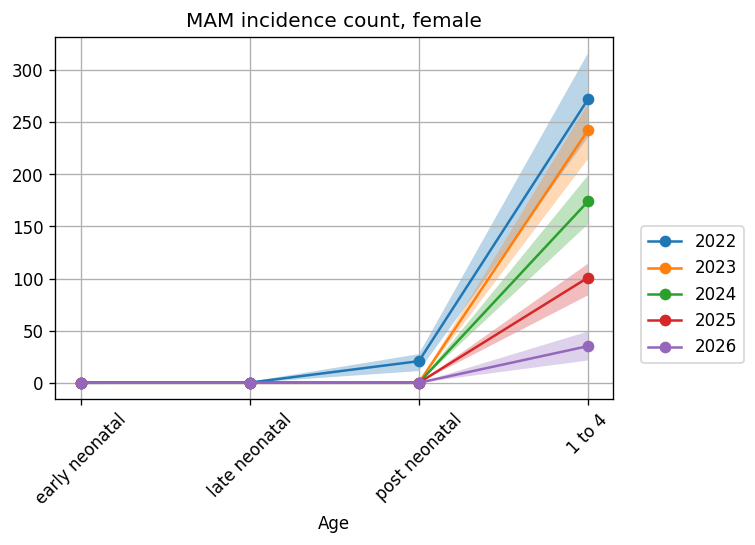

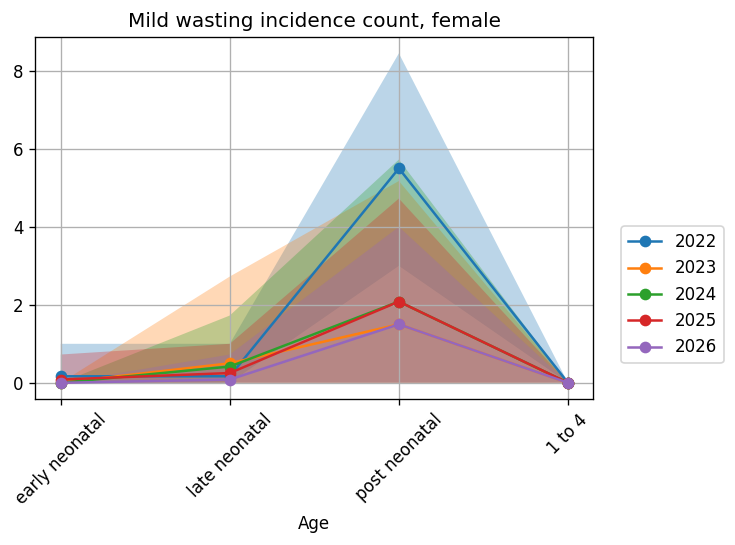

In [67]:
plot_sim_wasting(inc_count_sam, 'female', 'SAM incidence count')
plot_sim_wasting(inc_count_mam, 'female', 'MAM incidence count')
plot_sim_wasting(inc_count_mild, 'female', 'Mild wasting incidence count')

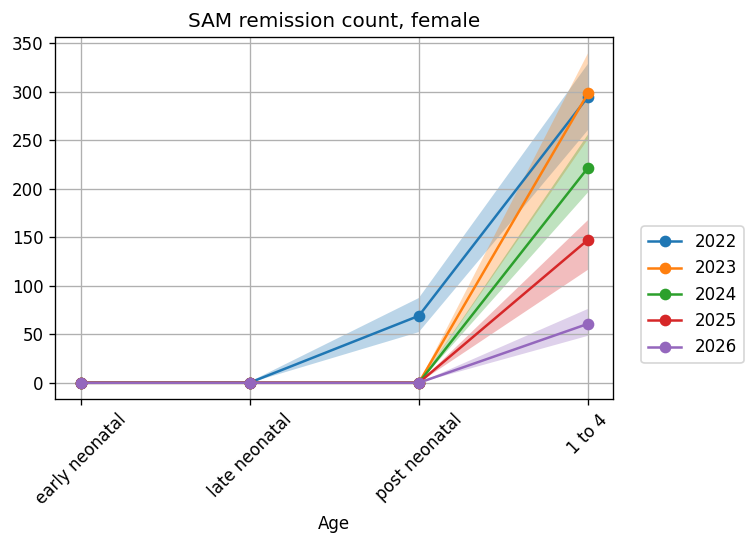

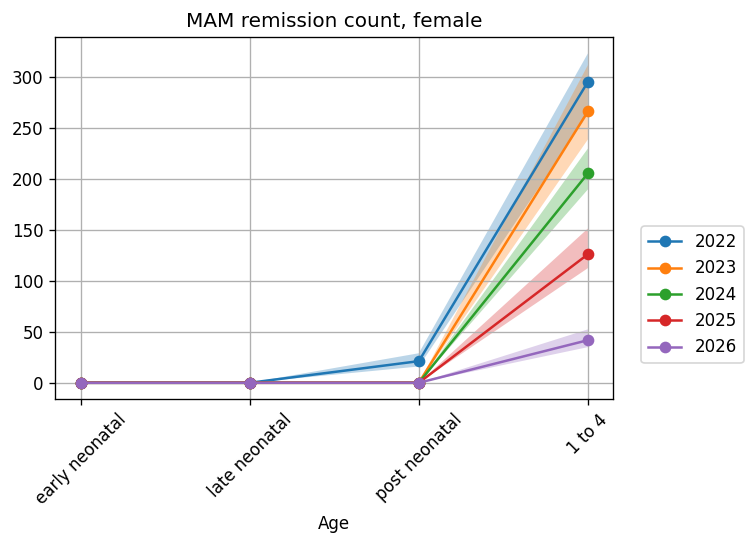

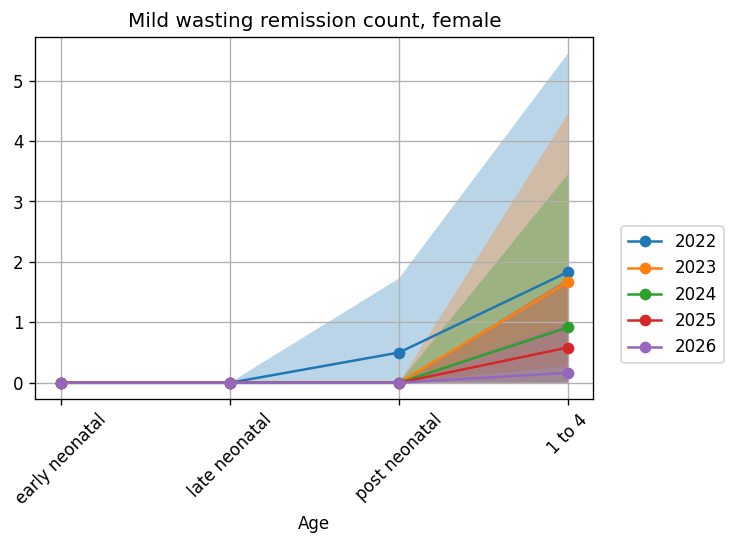

In [68]:
plot_sim_wasting_prevalence(rem_count_sam, 'female', 'SAM remission count')
plot_sim_wasting_prevalence(rem_count_mam, 'female', 'MAM remission count')
plot_sim_wasting_prevalence(rem_count_mild, 'female', 'Mild wasting remission count')